## Modeling and Error Analysis  
We already implemented Random Forest classifier as part of EDA and basic analysis.  
**GOAL**: In this section we will train different models and will do error analysis on the best model.

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from IPython.display import display

Loading cleaned dataset form pickle file

In [12]:
_CWD = '/content/drive/MyDrive/uOh/Thesis_Project/CODE'
# dataset_all_cleaned = pd.read_pickle('../data/dataset_all_cleaned.df')
dataset_all_cleaned = pd.read_pickle(_CWD+'/data/dataset_all_cleaned.df')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_all_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28138 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Query   28138 non-null  object
 1   Label   28138 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 659.5+ KB


In [6]:
X = dataset_all_cleaned['Query']
y = dataset_all_cleaned['Label']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
y_train.value_counts()

0    13624
1     6072
Name: Label, dtype: int64

In [9]:
y_test.value_counts()

0    5842
1    2600
Name: Label, dtype: int64

### Tokenization
We will tokenize data using counter vectorizer and TFIDF both.

In [10]:
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=2500)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [11]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=2500)
X_train_tfidfvec = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidfvec = tfidf_vectorizer.transform(X_test)

Let's save TFIDF vectorizer for future use.

In [14]:
with open(_CWD+'/model/tfidf_vec.sav', 'wb') as file:
  pickle.dump(tfidf_vectorizer, file)

#### Utility Function  
**Model evaluation:** To evaluate the model based on different scores and confusion matrics

In [ ]:
def eval_model(model, train_data, train_label, model_name = 'Model', cv=3):
  print(f'Evaluating {model_name}...')
  global X_test_tfidfvec
  global y_test
  train_acc_score = model.score(train_data, train_label)
  test_acc_score = model.score(X_test_tfidfvec, y_test)
  
  print('Training Accuracy = ',round(train_acc_score*100, 4), ' %')
  print('Testing Accuracy = ',round(test_acc_score*100, 4), ' %')
  
  y_predictions = model.predict(X_test_tfidfvec)
  print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")
  confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

  cross_val_f1 = cross_val_score(model, train_data, train_label, cv=cv, scoring='f1')
  print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

  fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
  roc_auc = auc(fpr, tpr)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
  print("roc_auc = ", round(roc_auc*100,4))

  figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
  confusion_mat.plot(ax=ax1)
  ax1.set_title('Confustion matrix')
  roc_display.plot(ax=ax2)
  ax2.set_title('ROC-AUC')
  figure.suptitle(model_name)

## K Nearest Neighbors Classifier

In [ ]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_tfidfvec, y_train)

KNeighborsClassifier()

Evaluating KNN Classifier...
Training Accuracy =  99.3958  %
Testing Accuracy =  99.4906  %
F1 Score for KNN Classifier: 99.1675 %
cross_validation f1-scores for KNN Classifier 
 [0.98371336 0.98751872 0.98701299]
roc_auc =  99.2158


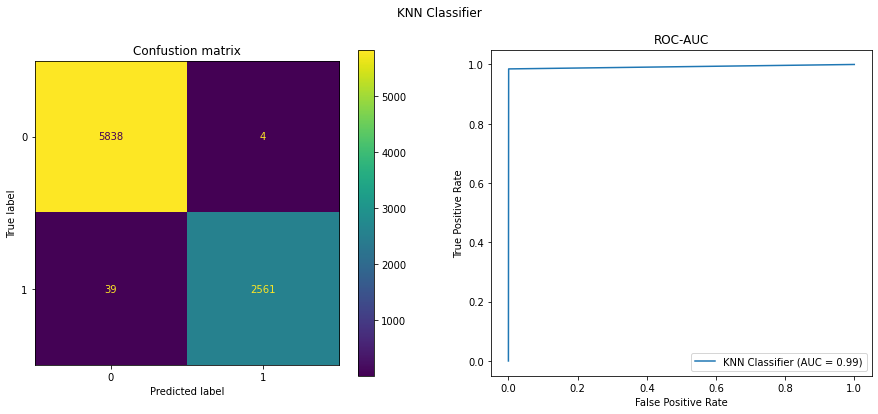

In [ ]:
eval_model(knn_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='KNN Classifier')

In [ ]:
knn_model_gcv = KNeighborsClassifier()
knn_params = {'n_neighbors':(1,3,5,7,9,11,13,19), 'metric':('euclidean','minkowski')}

In [ ]:
knn_clf_gcv = GridSearchCV(estimator = knn_model_gcv, param_grid = knn_params, n_jobs=-1, scoring='f1')

In [ ]:
knn_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ('euclidean', 'minkowski'),
                         'n_neighbors': (1, 3, 5, 7, 9, 11, 13, 19)},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(knn_clf_gcv.cv_results_)
cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
0,"{'metric': 'euclidean', 'n_neighbors': 1}",0.990968,0.000962,1
8,"{'metric': 'minkowski', 'n_neighbors': 1}",0.990968,0.000962,1
1,"{'metric': 'euclidean', 'n_neighbors': 3}",0.988362,0.000747,3
9,"{'metric': 'minkowski', 'n_neighbors': 3}",0.988362,0.000747,3
2,"{'metric': 'euclidean', 'n_neighbors': 5}",0.986336,0.001585,5
10,"{'metric': 'minkowski', 'n_neighbors': 5}",0.986336,0.001585,5
3,"{'metric': 'euclidean', 'n_neighbors': 7}",0.985744,0.001759,7
11,"{'metric': 'minkowski', 'n_neighbors': 7}",0.985744,0.001759,7
5,"{'metric': 'euclidean', 'n_neighbors': 11}",0.985739,0.001879,9
13,"{'metric': 'minkowski', 'n_neighbors': 11}",0.985739,0.001879,9


<AxesSubplot:xlabel='param_n_neighbors', ylabel='mean_test_score'>

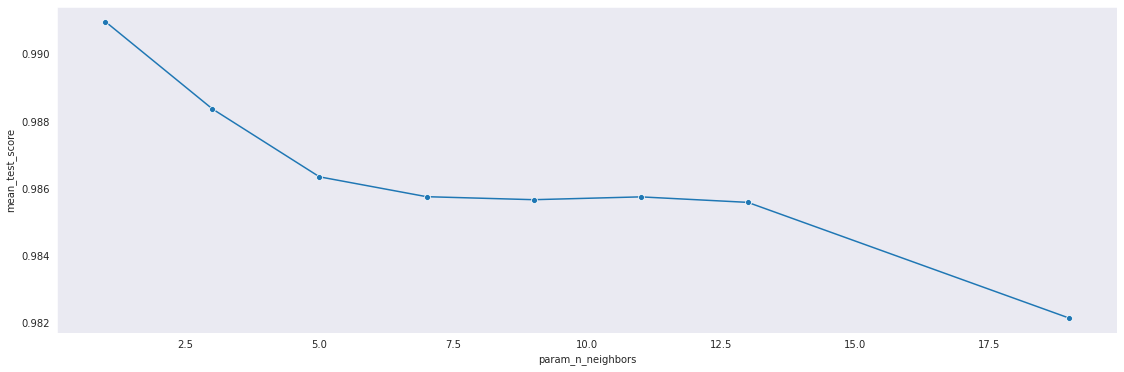

In [ ]:
sns.set_style("dark")
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results[cv_results['param_metric']=='minkowski'], x='param_n_neighbors', y='mean_test_score', marker="o")

In [ ]:
knn_model_tuned = KNeighborsClassifier(n_neighbors=7)

In [ ]:
knn_model_tuned.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

Evaluating KNN Classifier tuned...
Training Accuracy =  99.2283  %
Testing Accuracy =  99.4788  %
F1 Score for KNN Classifier tuned: 99.1479 %
cross_validation f1-scores for KNN Classifier tuned 
 [0.98320381 0.98725956 0.98650675]
roc_auc =  99.1965


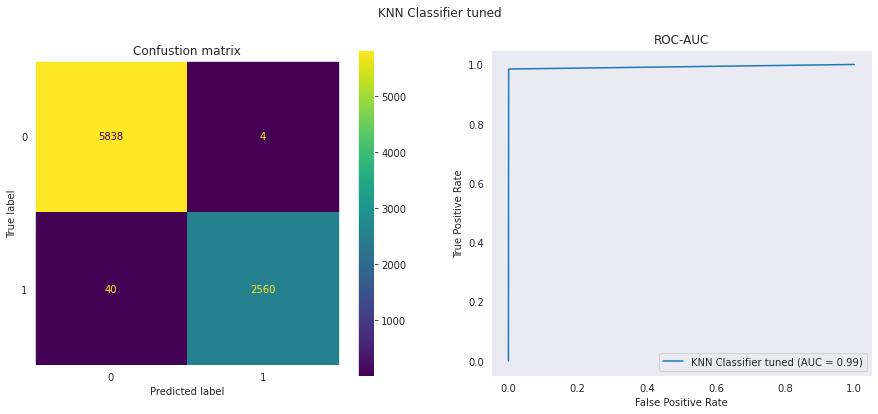

In [ ]:
knn_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(knn_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='KNN Classifier tuned')

**NOTE**: KNN model is working great but taking slightly more time due to high dimensionality

## Naive Bayes

In [ ]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidfvec, y_train)

MultinomialNB()

Evaluating Multinomial Naive Bayes...
Training Accuracy =  95.8824  %
Testing Accuracy =  95.5105  %
F1 Score for Multinomial Naive Bayes: 92.3512 %
cross_validation f1-scores for Multinomial Naive Bayes 
 [0.92364017 0.93451143 0.92440945]
roc_auc =  93.4266


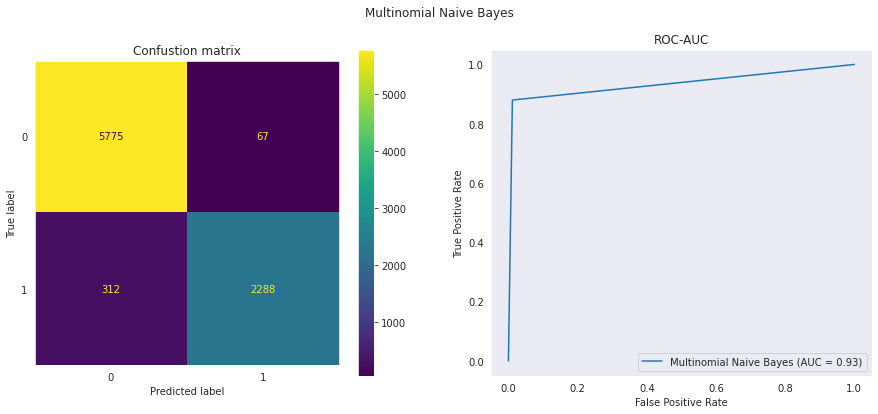

In [ ]:
eval_model(mnb_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Multinomial Naive Bayes')

In [ ]:
mnb_model_gcv = MultinomialNB()
mnb_params = {'alpha':(0, 0.1, 0.5, 1, 10, 100, 500)}

In [ ]:
mnb_clf_gcv = GridSearchCV(estimator = mnb_model_gcv, param_grid = mnb_params, n_jobs=-1, scoring='f1')

In [ ]:
mnb_clf_gcv.fit(X_train_tfidfvec, y_train)

/home/mayur/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (0, 0.1, 0.5, 1, 10, 100, 500)},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(mnb_clf_gcv.cv_results_)
cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
0,{'alpha': 0},0.927897,0.005156,1
1,{'alpha': 0.1},0.927875,0.004798,2
2,{'alpha': 0.5},0.927861,0.004630,3
3,{'alpha': 1},0.927730,0.004817,4
4,{'alpha': 10},0.919809,0.004819,5
5,{'alpha': 100},0.605906,0.015564,6
6,{'alpha': 500},0.000000,0.000000,7


<AxesSubplot:xlabel='param_alpha', ylabel='mean_test_score'>

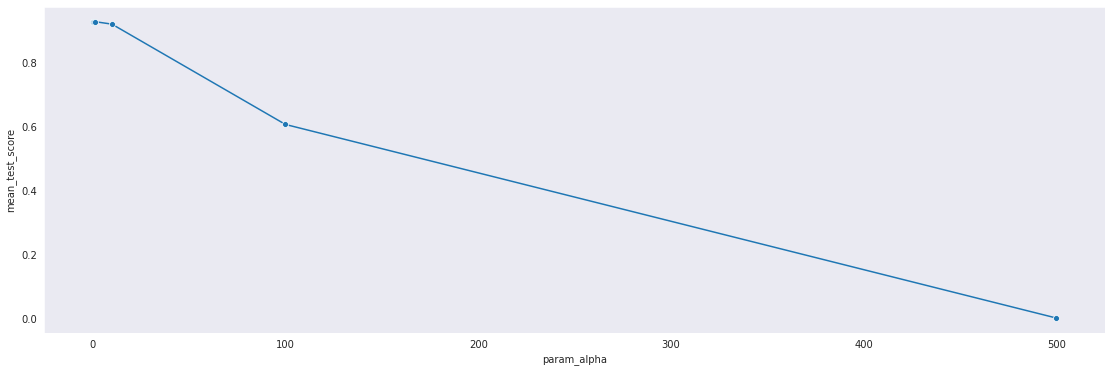

In [ ]:
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_alpha', y='mean_test_score', marker="o")

Using default value of alpha=1 works best.  
**NOTE**: Multinomial Naive Bayes is performing worst than KNN model.

## Logistic Regression

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_tfidfvec, y_train)

LogisticRegression()

Evaluating Logistic Regression...
Training Accuracy =  99.3095  %
Testing Accuracy =  99.3722  %
F1 Score for Logistic Regression: 98.9778 %
cross_validation f1-scores for Logistic Regression 
 [0.98602097 0.98829973 0.98779577]
roc_auc =  99.1835


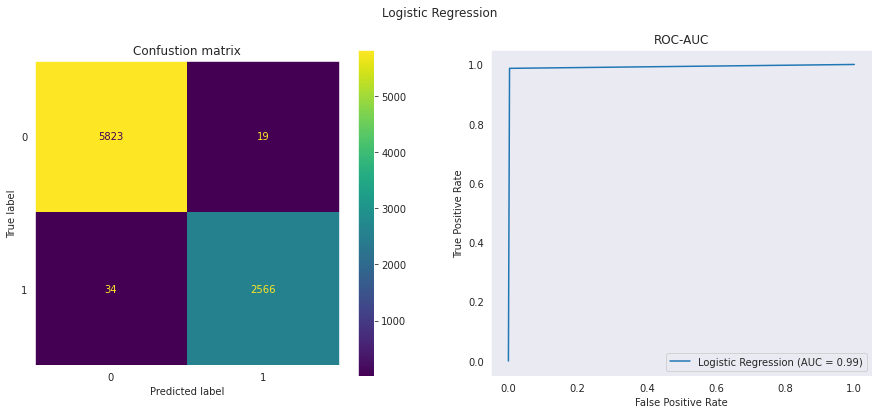

In [ ]:
eval_model(lr_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Logistic Regression')

In [ ]:
lr_model_gcv = LogisticRegression()
lr_params = {'C':(0.1, 0.5, 1.0, 5.0, 10.0), 'penalty':('l1', 'l2', 'elasticnet'), 'solver':('lbfgs', 'saga'), 'max_iter':[1000]}
lr_clf_gcv = GridSearchCV(estimator = lr_model_gcv, param_grid = lr_params, n_jobs=-1, scoring='f1')
lr_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0), 'max_iter': [1000],
                         'penalty': ('l1', 'l2', 'elasticnet'),
                         'solver': ('lbfgs', 'saga')},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(lr_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
19,"{'C': 5.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.991049,0.001205,1
27,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.990960,0.001529,2
26,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.990960,0.001529,2
25,"{'C': 10.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.990805,0.001246,4
21,"{'C': 5.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.990042,0.001027,5
20,"{'C': 5.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.990042,0.001027,5
13,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.988963,0.001322,7
15,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}",0.987792,0.001266,8
14,"{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}",0.987792,0.001266,8
7,"{'C': 0.5, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}",0.987215,0.001803,10


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

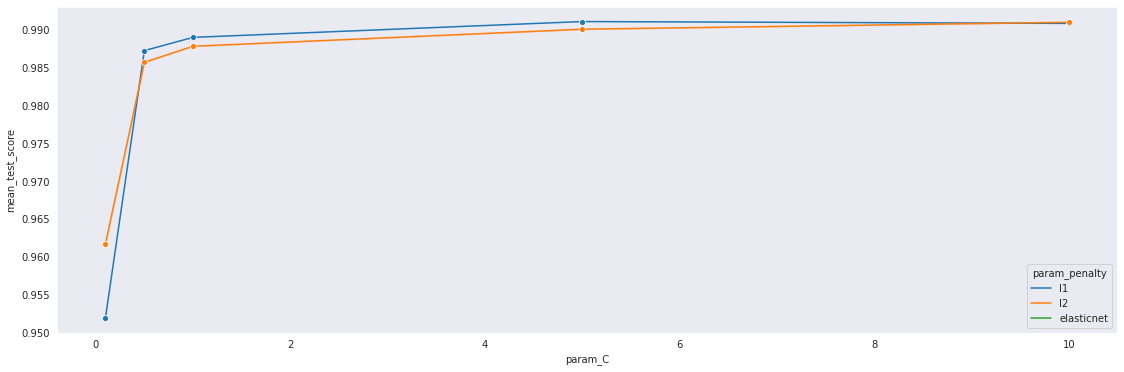

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
figure = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_C', y='mean_test_score', hue='param_penalty' ,marker="o")

Here we can see that C=5.0 and 10.0 with solver='saga' and 'l1' penalty work best for Logistic Regression model.  
We should use C=5.0 to which applies more regularization than C=10.0. This helps to overcome overfitting problem.

In [ ]:
lr_model_tuned = LogisticRegression(C=5.0, penalty='l1', solver= 'saga', max_iter=1000)
lr_model_tuned.fit(X_train_tfidfvec, y_train)

LogisticRegression(C=5.0, max_iter=1000, penalty='l1', solver='saga')

Evaluating Logistic Regression Tuned...
Training Accuracy =  99.736  %
Testing Accuracy =  99.5854  %
F1 Score for Logistic Regression Tuned: 99.3237 %


/home/mayur/.local/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


cross_validation f1-scores for Logistic Regression Tuned 
 [0.98953662 0.99032018 0.99180531]
roc_auc =  99.3803


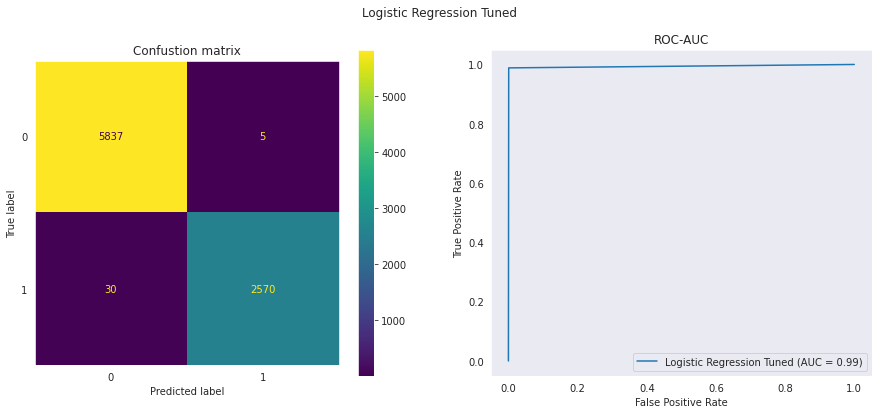

In [ ]:
eval_model(lr_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='Logistic Regression Tuned')

We are able to improve f1-score by hyper paramater tuning.  
**NOTE**: Logistic regression is faster and better than KNN model.

## Support Vector Classifier

In [ ]:
svc_model = SVC()
svc_model.fit(X_train_tfidfvec, y_train)

SVC()

Evaluating Support Vector Classifier...
Training Accuracy =  99.736  %
Testing Accuracy =  99.6091  %
F1 Score for Support Vector Classifier: 99.3618 %
cross_validation f1-scores for Support Vector Classifier 
 [0.99128269 0.99279145 0.99054256]
roc_auc =  99.3867


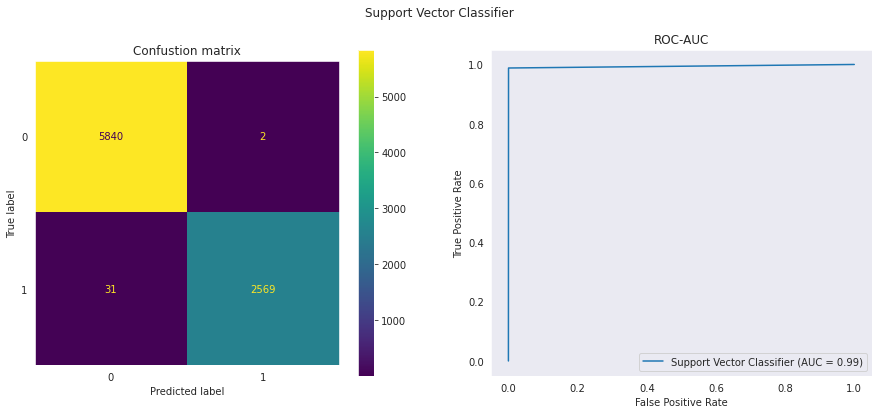

In [ ]:
eval_model(svc_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Support Vector Classifier')

In [ ]:
svc_model_gcv = SVC()
svc_params = {'kernel':('linear', 'rbf'), 'C':(0.1, 0.5, 1.0, 5.0, 10.0)}
svc_clf_gcv = GridSearchCV(estimator = svc_model_gcv, param_grid = svc_params, n_jobs=-1, scoring='f1')
svc_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': (0.1, 0.5, 1.0, 5.0, 10.0),
                         'kernel': ('linear', 'rbf')},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(svc_clf_gcv.cv_results_)
cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
6,"{'C': 5.0, 'kernel': 'linear'}",0.992548,0.000949,1
7,"{'C': 5.0, 'kernel': 'rbf'}",0.992379,0.000415,2
9,"{'C': 10.0, 'kernel': 'rbf'}",0.992379,0.000415,2
4,"{'C': 1.0, 'kernel': 'linear'}",0.992298,0.000773,4
8,"{'C': 10.0, 'kernel': 'linear'}",0.992132,0.000696,5
5,"{'C': 1.0, 'kernel': 'rbf'}",0.992044,0.000481,6
3,"{'C': 0.5, 'kernel': 'rbf'}",0.991120,0.000630,7
2,"{'C': 0.5, 'kernel': 'linear'}",0.990116,0.001704,8
1,"{'C': 0.1, 'kernel': 'rbf'}",0.987674,0.000864,9
0,"{'C': 0.1, 'kernel': 'linear'}",0.985632,0.000935,10


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

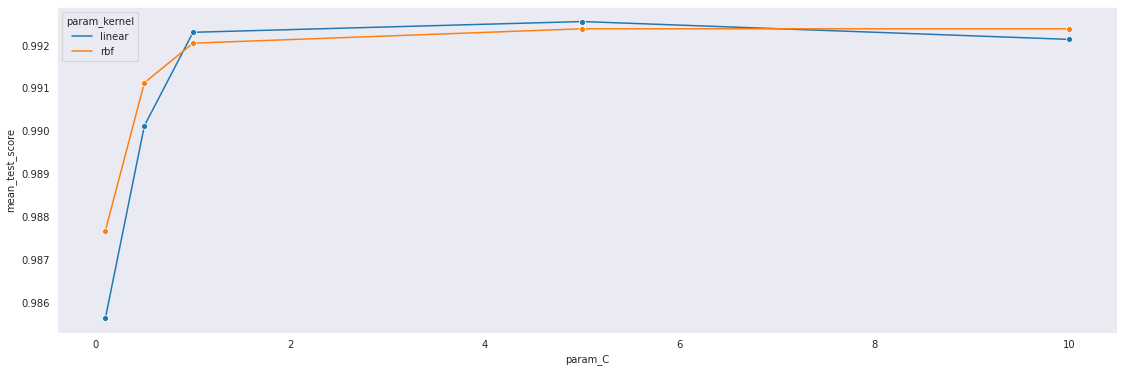

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
figure = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_C', y='mean_test_score', hue='param_kernel' ,marker="o")

Here we can see that linear SVC with C=5.0 is working best following by rbf kernel.

Evaluating Support Vector Classifier Tuned...
Training Accuracy =  99.7106  %
Testing Accuracy =  99.6209  %
F1 Score for Support Vector Classifier Tuned: 99.3815 %
cross_validation f1-scores for Support Vector Classifier Tuned 
 [0.98979846 0.99304521 0.99080745]
roc_auc =  99.4166


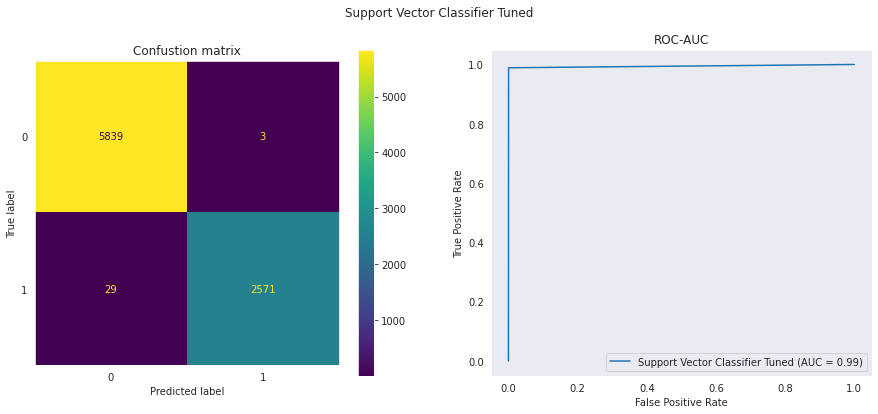

In [ ]:
svc_model_tuned = SVC(kernel='linear', C=5.0)
svc_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(svc_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='Support Vector Classifier Tuned')

**NOTE**: SVC with linear kernel is performing slightly better than Logistic Regression.

## Random Forest Classifier

Evaluating Random Forest Classifier...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.6091  %
F1 Score for Random Forest Classifier: 99.3623 %
cross_validation f1-scores for Random Forest Classifier 
 [0.99304175 0.99304521 0.99204771]
roc_auc =  99.4081


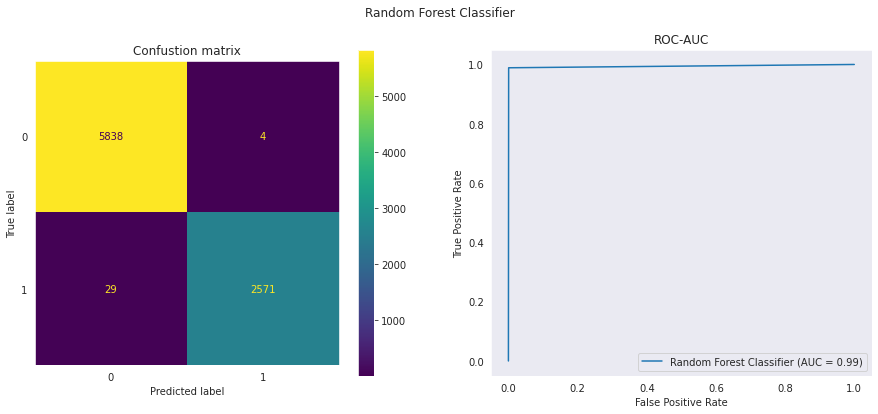

In [ ]:
RFC_model = RandomForestClassifier()
RFC_model.fit(X_train_tfidfvec, y_train)
eval_model(RFC_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='Random Forest Classifier')

In [ ]:
RFC_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
RFC_model_gcv = RandomForestClassifier()
RFC_params = {'n_estimators':(10,50,100,200,300), 'class_weight':(None, 'balanced', 'balanced_subsample')}
RFC_clf_gcv = GridSearchCV(estimator = RFC_model_gcv, param_grid = RFC_params, n_jobs=-1, scoring='f1')
RFC_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': (None, 'balanced',
                                          'balanced_subsample'),
                         'n_estimators': (10, 50, 100, 200, 300)},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(RFC_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
6,"{'class_weight': 'balanced', 'n_estimators': 50}",0.993460,0.000412,1
13,"{'class_weight': 'balanced_subsample', 'n_estimators': 200}",0.993377,0.000262,2
8,"{'class_weight': 'balanced', 'n_estimators': 200}",0.993295,0.000167,3
10,"{'class_weight': 'balanced_subsample', 'n_estimators': 10}",0.993212,0.000415,4
7,"{'class_weight': 'balanced', 'n_estimators': 100}",0.993212,0.000198,5
4,"{'class_weight': None, 'n_estimators': 300}",0.993212,0.000208,6
9,"{'class_weight': 'balanced', 'n_estimators': 300}",0.993212,0.000208,6
14,"{'class_weight': 'balanced_subsample', 'n_estimators': 300}",0.993211,0.000329,8
2,"{'class_weight': None, 'n_estimators': 100}",0.993130,0.000198,9
11,"{'class_weight': 'balanced_subsample', 'n_estimators': 50}",0.993129,0.000201,10


<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

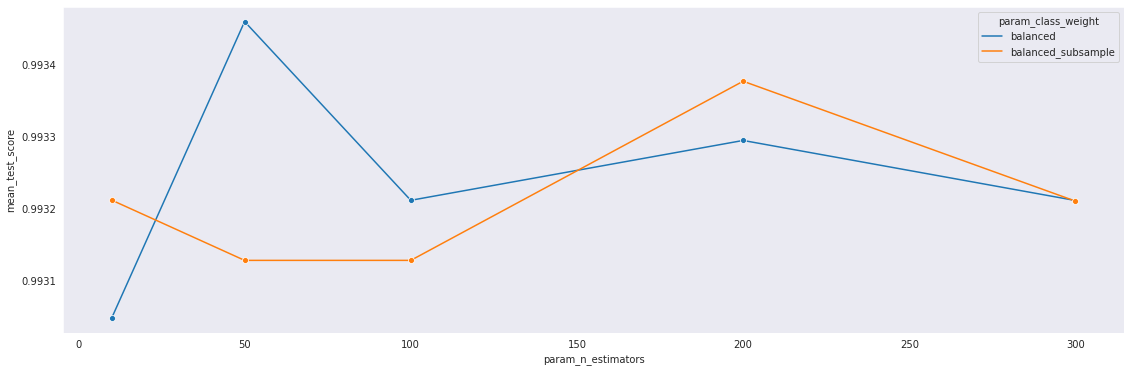

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_n_estimators', y='mean_test_score', hue='param_class_weight' ,marker="o")

We can see that n_estimators=200 and class_weight='balanced_subsample' works best. We should also consider n_estimators=50 and class_weight='balanced', beacause it is having smaller standard deviation in score.

Evaluating Random Forest Classifier Tuned...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.6091  %
F1 Score for Random Forest Classifier Tuned: 99.3621 %
cross_validation f1-scores for Random Forest Classifier Tuned 
 [0.99304175 0.99279503 0.99254473]
roc_auc =  99.3974


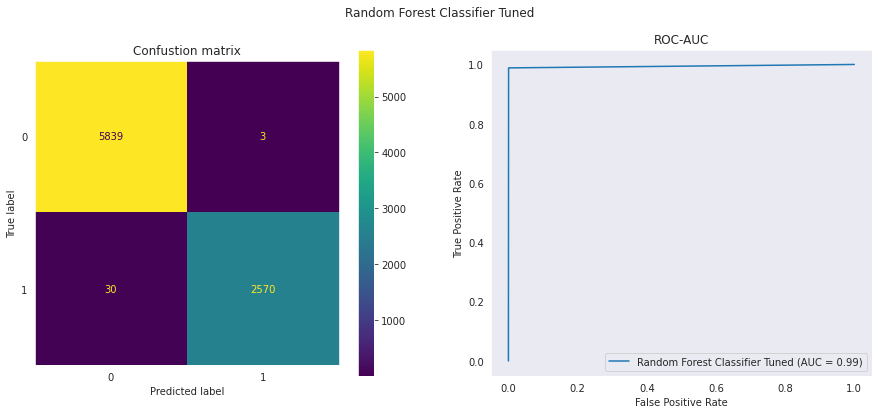

In [ ]:
RFC_model_tuned = RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200)
RFC_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(RFC_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='Random Forest Classifier Tuned')

Evaluating Random Forest Classifier Tuned 2...
Training Accuracy =  99.7715  %
Testing Accuracy =  99.6209  %
F1 Score for Random Forest Classifier Tuned 2: 99.3815 %
cross_validation f1-scores for Random Forest Classifier Tuned 2 
 [0.99254844 0.99304521 0.99254102]
roc_auc =  99.4166


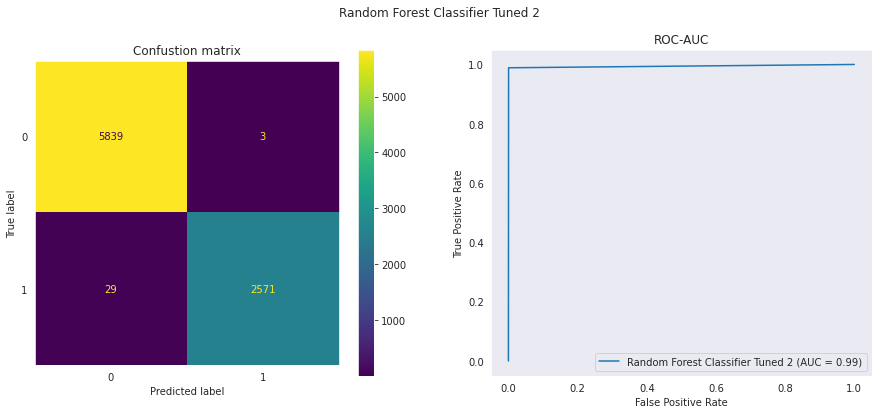

In [ ]:
RFC_model_tuned_2 = RandomForestClassifier(class_weight='balanced', n_estimators=50)
RFC_model_tuned_2.fit(X_train_tfidfvec, y_train)
eval_model(RFC_model_tuned_2, train_data=X_train_tfidfvec, train_label=y_train, model_name='Random Forest Classifier Tuned 2')

**NOTE**: Random Forest Classifier is working same as Support Vector Classifier but RFC is faster than SVC.

## Gradient Boosted Decision Tree Classifier

Evaluating GBDT Classifier...
Training Accuracy =  99.1826  %
Testing Accuracy =  99.2656  %
F1 Score for GBDT Classifier: 98.7971 %
cross_validation f1-scores for GBDT Classifier 
 [0.98451548 0.98527577 0.9842618 ]
roc_auc =  98.8931


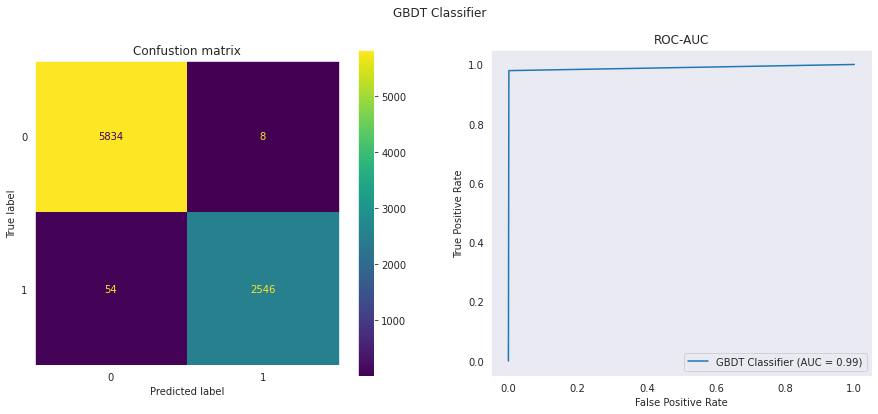

In [ ]:
GBDT_model = GradientBoostingClassifier()
GBDT_model.fit(X_train_tfidfvec, y_train)
eval_model(GBDT_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='GBDT Classifier')

In [ ]:
GBDT_model_gcv = GradientBoostingClassifier()
GBDT_params = {'n_estimators':(50,100,200,300), 'learning_rate':(0.01, 0.1, 0.5, 1.0)}
GBDT_clf_gcv = GridSearchCV(estimator = GBDT_model_gcv, param_grid = GBDT_params, n_jobs=-1, scoring='f1')
GBDT_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': (0.01, 0.1, 0.5, 1.0),
                         'n_estimators': (50, 100, 200, 300)},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(GBDT_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
9,"{'learning_rate': 0.5, 'n_estimators': 100}",0.989325,0.001758,1
8,"{'learning_rate': 0.5, 'n_estimators': 50}",0.989237,0.001110,2
7,"{'learning_rate': 0.1, 'n_estimators': 300}",0.989069,0.000505,3
10,"{'learning_rate': 0.5, 'n_estimators': 200}",0.988993,0.001621,4
11,"{'learning_rate': 0.5, 'n_estimators': 300}",0.988907,0.001557,5
6,"{'learning_rate': 0.1, 'n_estimators': 200}",0.987807,0.001469,6
12,"{'learning_rate': 1.0, 'n_estimators': 50}",0.985956,0.002181,7
13,"{'learning_rate': 1.0, 'n_estimators': 100}",0.985792,0.002287,8
15,"{'learning_rate': 1.0, 'n_estimators': 300}",0.985386,0.002010,9
14,"{'learning_rate': 1.0, 'n_estimators': 200}",0.985297,0.002063,10


For learning rate 0.5 we are able to get almost same test_score with respest to learning rate 0.1 and n_estimators=300.  
But the standard deviation is less in case of smaller learning rate. So it is better to choose learning rate 0.1 and n_estimators=300.

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

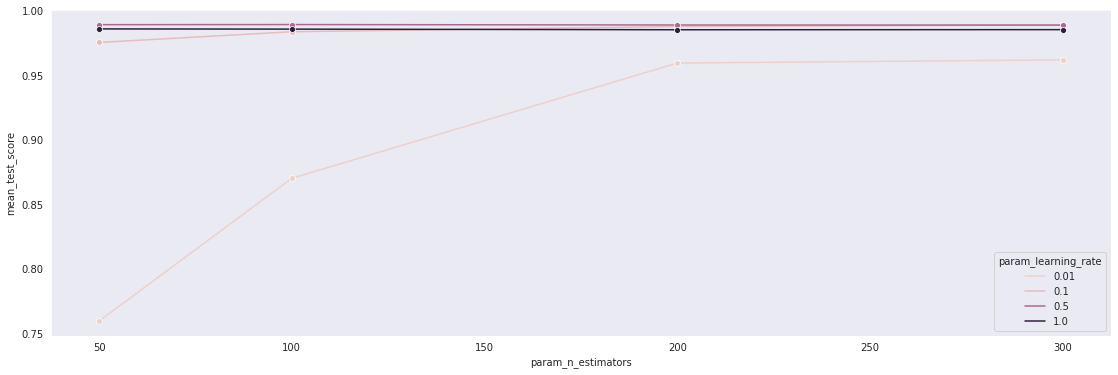

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(19,6))
fig = plt.figure(figsize=(19,6))
sns.lineplot(data = cv_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate' ,marker="o")

Evaluating GBDT Classifier Tuned...
Training Accuracy =  99.6954  %
Testing Accuracy =  99.4906  %
F1 Score for GBDT Classifier Tuned: 99.1684 %
cross_validation f1-scores for GBDT Classifier Tuned 
 [0.98956262 0.98956781 0.9880597 ]
roc_auc =  99.2478


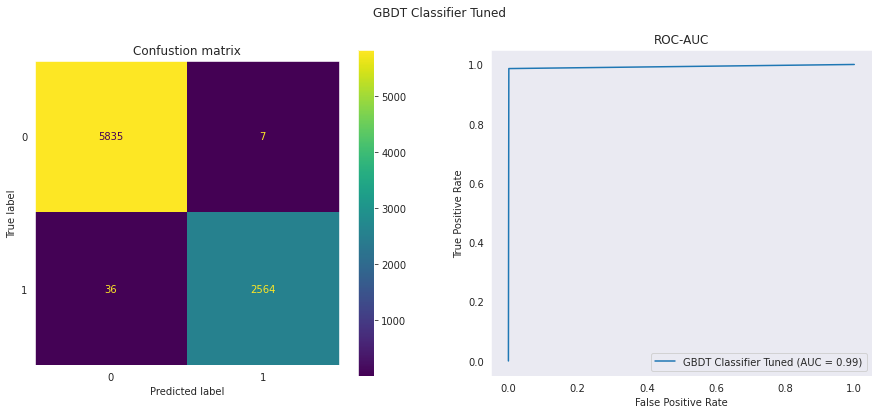

In [ ]:
GBDT_model_tuned = GradientBoostingClassifier(learning_rate=0.1, n_estimators=300)
GBDT_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(GBDT_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='GBDT Classifier Tuned')

Evaluating GBDT Classifier Tuned 2...
Training Accuracy =  99.7665  %
Testing Accuracy =  99.5617  %
F1 Score for GBDT Classifier Tuned 2: 99.2845 %
cross_validation f1-scores for GBDT Classifier Tuned 2 
 [0.98981366 0.99055196 0.98880318]
roc_auc =  99.3311


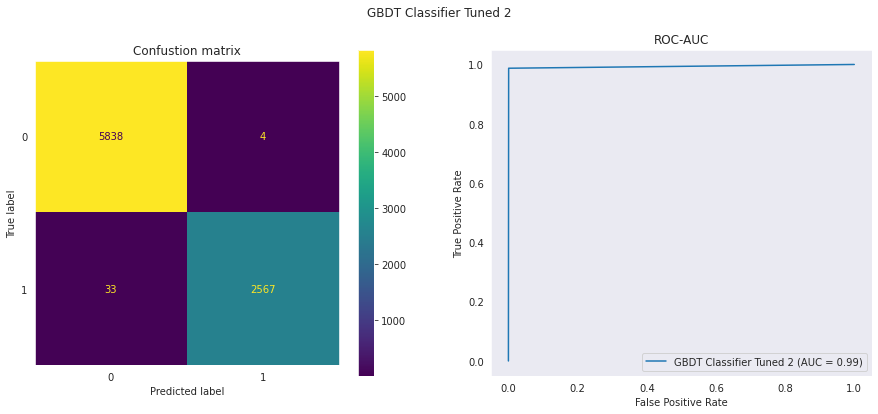

In [ ]:
GBDT_model_tuned_2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500)
GBDT_model_tuned_2.fit(X_train_tfidfvec, y_train)
eval_model(GBDT_model_tuned_2, train_data=X_train_tfidfvec, train_label=y_train, model_name='GBDT Classifier Tuned 2')

Increasing Number of estimators improved GBDT model f1-score. But it takes long time to run.  
**NOTE**: GBDT is not performing better than RFC and SVC.

Evaluating MLP Classifier...
Training Accuracy =  99.7614  %
Testing Accuracy =  99.5973  %
F1 Score for MLP Classifier: 99.3429 %
cross_validation f1-scores for MLP Classifier 
 [0.99029609 0.99180531 0.99181345]
roc_auc =  99.3888


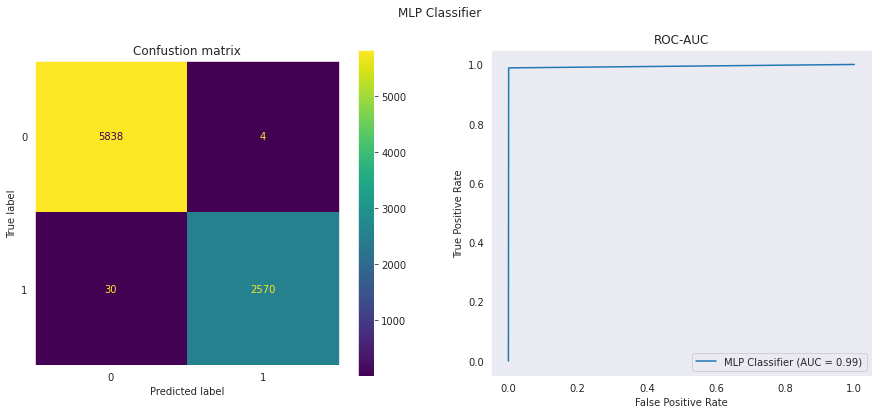

In [ ]:
MLP_model = MLPClassifier()
MLP_model.fit(X_train_tfidfvec, y_train)
eval_model(MLP_model, train_data=X_train_tfidfvec, train_label=y_train, model_name='MLP Classifier')

In [ ]:
MLP_model_gcv = MLPClassifier()
MLP_params = {'hidden_layer_sizes':((50,),(100,),(200,),(300,),(500,200,))}
MLP_clf_gcv = GridSearchCV(estimator = MLP_model_gcv, param_grid = MLP_params, n_jobs=-1, scoring='f1')
MLP_clf_gcv.fit(X_train_tfidfvec, y_train)

GridSearchCV(estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'hidden_layer_sizes': ((50,), (100,), (200,), (300,),
                                                (500, 200))},
             scoring='f1')

In [ ]:
cv_results = pd.DataFrame(MLP_clf_gcv.cv_results_)
with pd.option_context('display.max_colwidth', None):
  display(cv_results.loc[:,['params', 'mean_test_score','std_test_score',	'rank_test_score']].sort_values('rank_test_score'))

,params,mean_test_score,std_test_score,rank_test_score
3,"{'hidden_layer_sizes': (300,)}",0.992300,0.000895,1
4,"{'hidden_layer_sizes': (500, 200)}",0.992222,0.000313,2
0,"{'hidden_layer_sizes': (50,)}",0.992218,0.000928,3
1,"{'hidden_layer_sizes': (100,)}",0.992217,0.000849,4
2,"{'hidden_layer_sizes': (200,)}",0.992133,0.000950,5


<AxesSubplot:xlabel='param_hidden_layer_sizes', ylabel='mean_test_score'>

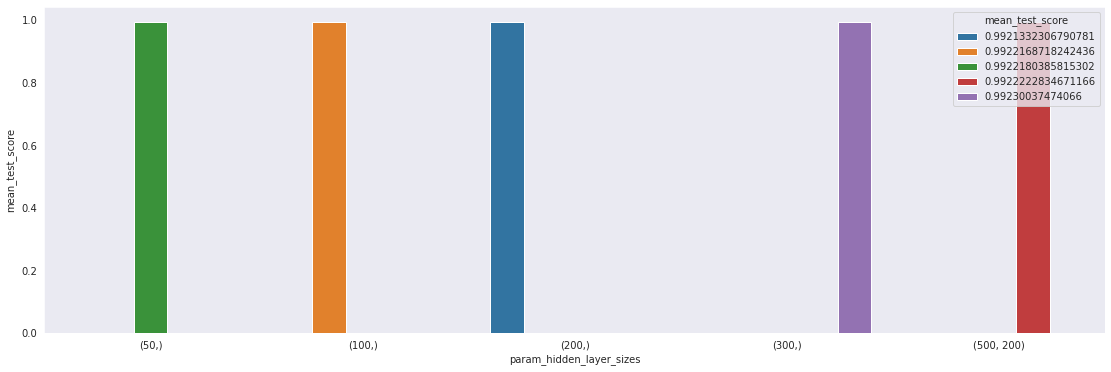

In [ ]:
fig = plt.figure(figsize=(19,6))
sns.barplot(data = cv_results, x='param_hidden_layer_sizes', y='mean_test_score', hue='mean_test_score')

Evaluating MLP Classifier Tuned...
Training Accuracy =  99.7665  %
Testing Accuracy =  99.6091  %
F1 Score for MLP Classifier Tuned: 99.3623 %
cross_validation f1-scores for MLP Classifier Tuned 
 [0.99128992 0.99295483 0.99296066 0.99174236 0.99255583]
roc_auc =  99.4081


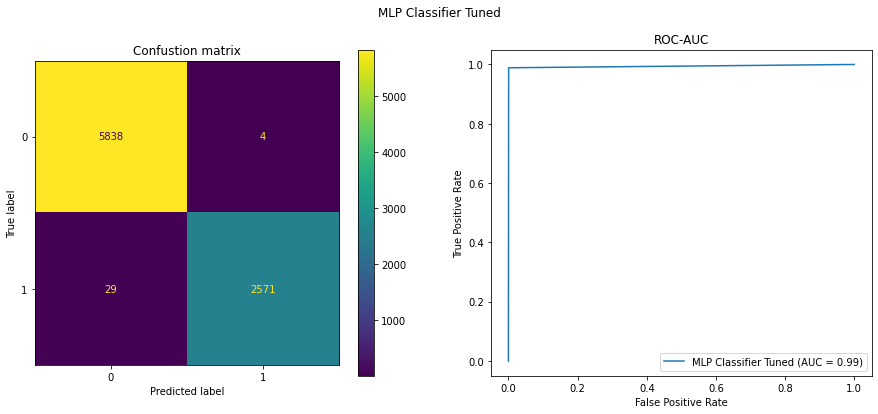

In [ ]:
MLP_model_tuned = MLPClassifier(hidden_layer_sizes=(300,))
MLP_model_tuned.fit(X_train_tfidfvec, y_train)
eval_model(MLP_model_tuned, train_data=X_train_tfidfvec, train_label=y_train, model_name='MLP Classifier Tuned')

With MLP classifier we are able to achieve same performance as Random Forest and support vector classifier.  
But it is taking considerably more time compare to any other models.  

# Error Analysis

We will use Random Forest Model with **n_estimators** = 50 and **class_weight** = 'balanced' as final model.  
We have 29 False Negatives and 3 Flase Positives with F1 Score of 99.3815%.

In [ ]:
final_RFC_model = RandomForestClassifier(n_estimators=50, class_weight='balanced')
final_RFC_model.fit(X_train_tfidfvec, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50)

In [ ]:
with open('../model/final_RFC_model.model', 'wb') as file:
  pickle.dump(final_RFC_model, file)

In [ ]:
y_pred = final_RFC_model.predict(X_test_tfidfvec)
y_pred.shape

(8442,)

In [ ]:
error_idx = y_test.index[y_pred!=y_test]

In [ ]:
error_points = pd.DataFrame()
error_points['Qurey'] = X_test[error_idx]
error_points['True_Label'] = y_test[error_idx]
error_points['Pred_Label'] = y_pred[y_pred != y_test]

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(error_points)

,Qurey,True_Label,Pred_Label
19890,select customername city country from customers order by case when city is null then country else city end,0,1
19305,os,1,0
19314,handler,1,0
19312,0,1,0
25803,insert into available doctor sleep happened values lay wrapped function,0,1
658,declare q nvarchar 4000 select q,1,0
106,s,1,0
851,objectclass,1,0
627,having 1 1,1,0
573,declare s varchar 8000 select s 0x73656c,1,0


In [ ]:
raw_dataset = pd.read_csv("/content/drive/MyDrive/uOh/Thesis_Project/CODE/data/Modified_SQL_Dataset.csv")
# raw_dataset = pd.read_csv("../data/Modified_SQL_Dataset.csv")

In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(raw_dataset.loc[error_idx,:])

,Query,Label
19890,"SELECT CustomerName, City, Country FROM Customers ORDER BY ( CASE WHEN City IS NULL THEN Country ELSE City END ) ;",0
19305,os,1
19314,handler,1
19312,0,1
25803,"INSERT INTO available ( doctor, sleep, happened ) VALUES ( 'lay', 'wrapped', 'function' )",0
658,declare @q nvarchar ( 4000 ) select @q =,1
106,s,1
851,* ( | ( objectclass = * ) ),1
627,having 1 = 1--,1
573,declare @s varchar ( 8000 ) select @s = 0x73656c ...,1


We can see that most of the queries does not make sense. Some queries look normal trying to access database information or have syntax error. It is tough to identify normal query and query with small syntax error.  

Next, we will try to use some extra features with our best model to see if it helps to improve the error further.  
1. **Speacial Characters Count** : Number of special characters in the raw query
2. **Query Length** : Number of words in the query after removing special characters
3. **Count of number=number pattern** : Number of time some digit = digit pattern occurs in the query. eg 15 = 5, 1=1

In [ ]:
dataset_FE = dataset_all_cleaned.copy()

In [ ]:
# dataset_FE['Query_length'] =
no_of_special_chars = raw_dataset['Query'].map(lambda x:len(re.findall('[^a-zA-Z0-9\s]',x)))
query_length = dataset_all_cleaned['Query'].map(lambda x:len(x.split()))
no_of_num_eq_num = raw_dataset['Query'].map(lambda x:len(re.findall(r'\d\s*=\s*\d',x))).sort_values(ascending=False)

In [ ]:
dataset_FE['num_eq_num'] = no_of_num_eq_num.loc[dataset_FE.index]
dataset_FE['num_sc'] = no_of_special_chars.loc[dataset_FE.index]
dataset_FE['q_len'] = query_length

In [ ]:
X_train_tfidf_FE = X_train_tfidfvec.copy()
X_test_tfidf_FE = X_test_tfidfvec.copy()

In [ ]:
X_train_tfidf_FE = pd.DataFrame(data=X_train_tfidfvec.toarray(),columns=tfidf_vectorizer.get_feature_names(), index=X_train.index)
X_train_tfidf_FE['num_sc'] = dataset_FE.loc[X_train.index]['num_sc']
X_train_tfidf_FE['q_len'] = dataset_FE.loc[X_train.index]['q_len']
X_train_tfidf_FE['num_eq_num'] = dataset_FE.loc[X_train.index]['num_eq_num']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_tfidf_FE

,01,01 and,01 and 1996,06,06 15,06 15 09,07,07 01,07 01 and,07 31,09,09 34,09 34 21,0x28,0x28 end,0x28 end and,0x2e,0x2e 0x7171706a71,0x2e 0x7171706a71 select,0x4c4d6142,0x4c4d6142 and,0x52515a50,0x5c,0x5c 0x7171706a71,0x5c 0x7171706a71 select,0x5c benchmark,0x5c benchmark 5000000,0x694a4745,0x694a4745 and,0x7171706a71,0x7171706a71 select,0x7171706a71 select case,0x7171706a71 select elt,0x717a767a71,0x717a767a71 0x78,0x717a767a71 0x78 8446744073709551610,0x717a767a71 0x78 and,0x717a767a71 1161,0x717a767a71 1161 and,0x717a767a71 8666,...,wing,wise,wish,without,women,won,wonderful,worse,worth,would,wp,wp options,wp options where,wp postmeta,wp postmeta where,wp posts,wp posts from,wp posts id,wp posts menu,wp posts post,wp posts where,wp term,wrapped,write,writer,wrong,xmltype,xmltype chr,xmltype chr 60,yard,ydpu,ydpu and,year,yes,yourself,zipper,zulu,num_sc,q_len,num_eq_num
26897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,1,5,0
15091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0,2,0
25389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0,4,0
22109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,5,9,0
21007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,4,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,2,5,0
7143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,13,12,0
1525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311098,0.34015,0.0,0.0,0.0,0.0,0.0,17,12,0
18485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
X_test_tfidf_FE = pd.DataFrame(data=X_test_tfidfvec.toarray(),columns=tfidf_vectorizer.get_feature_names(), index=X_test.index)
X_test_tfidf_FE['num_sc'] = dataset_FE.loc[X_test.index]['num_sc']
X_test_tfidf_FE['q_len'] = dataset_FE.loc[X_test.index]['q_len']
X_test_tfidf_FE['num_eq_num'] = dataset_FE.loc[X_test.index]['num_eq_num']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_test_tfidf_FE

,01,01 and,01 and 1996,06,06 15,06 15 09,07,07 01,07 01 and,07 31,09,09 34,09 34 21,0x28,0x28 end,0x28 end and,0x2e,0x2e 0x7171706a71,0x2e 0x7171706a71 select,0x4c4d6142,0x4c4d6142 and,0x52515a50,0x5c,0x5c 0x7171706a71,0x5c 0x7171706a71 select,0x5c benchmark,0x5c benchmark 5000000,0x694a4745,0x694a4745 and,0x7171706a71,0x7171706a71 select,0x7171706a71 select case,0x7171706a71 select elt,0x717a767a71,0x717a767a71 0x78,0x717a767a71 0x78 8446744073709551610,0x717a767a71 0x78 and,0x717a767a71 1161,0x717a767a71 1161 and,0x717a767a71 8666,...,wing,wise,wish,without,women,won,wonderful,worse,worth,would,wp,wp options,wp options where,wp postmeta,wp postmeta where,wp posts,wp posts from,wp posts id,wp posts menu,wp posts post,wp posts where,wp term,wrapped,write,writer,wrong,xmltype,xmltype chr,xmltype chr 60,yard,ydpu,ydpu and,year,yes,yourself,zipper,zulu,num_sc,q_len,num_eq_num
13356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
13109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,0
20932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,9,0
27932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,0
28507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,8,0
13513,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0
22529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,12,0
25560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.

# RFC Model with FE
We have added 3 more features into the train and test dataset along with TFIDF featrues.  
Let's train RFC model with new dataset.

In [ ]:
final_RFC_model_FE = RandomForestClassifier(n_estimators=50, class_weight='balanced', random_state=42)
final_RFC_model_FE.fit(X_train_tfidf_FE, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

Evaluating RFC model with FE...
Training Accuracy =  99.9086  %
Testing Accuracy =  99.7394  %
F1 Score for RFC model with FE: 99.5756 %
cross_validation f1-scores for RFC model with FE 
 [0.99429139 0.99304866 0.99628437]
roc_auc =  99.6089


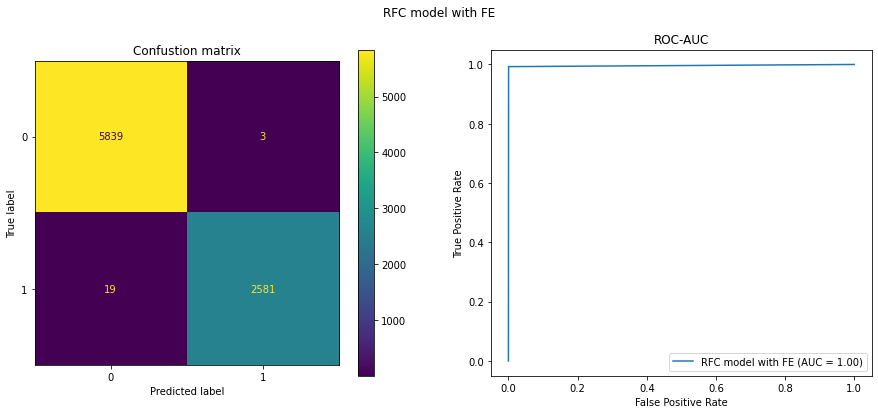

In [ ]:
model = final_RFC_model_FE
train_data=X_train_tfidf_FE
train_label=y_train
model_name='RFC model with FE'

print(f'Evaluating {model_name}...')
train_acc_score = model.score(train_data, train_label)
test_acc_score = model.score(X_test_tfidf_FE, y_test)

print('Training Accuracy = ',round(train_acc_score*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score*100, 4), ' %')

y_predictions = model.predict(X_test_tfidf_FE)
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

cross_val_f1 = cross_val_score(model, train_data, train_label, cv=3, scoring='f1')
print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);

We are able to improve f1 score slightly by improving *False negatives* and *False positives*.
So total errors also got reduced.

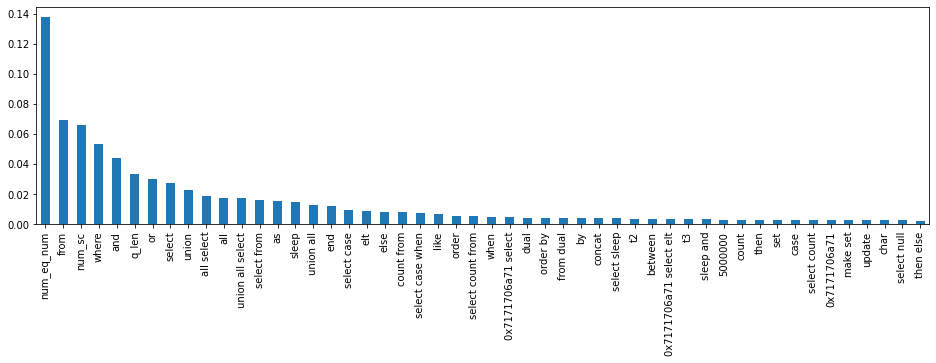

In [ ]:
importances = final_RFC_model_FE.feature_importances_
forest_importances = pd.Series(importances, index=X_train_tfidf_FE.columns)
forest_importances.sort_values(inplace=True, ascending=False)
forest_importances[:50].plot(kind='bar', figsize=(16,4))

Newly added features are having high importance and are top 3 features, which helped to improve the model performance and reduce error.  

In [ ]:
error_idx = y_test.index[final_RFC_model_FE.predict(X_test_tfidf_FE)!=y_test]
with pd.option_context('display.max_colwidth', None):
  display(raw_dataset.loc[error_idx,:])

,Query,Label
19890,"SELECT CustomerName, City, Country FROM Customers ORDER BY ( CASE WHEN City IS NULL THEN Country ELSE City END ) ;",0
19305,os,1
19314,handler,1
19312,0,1
106,s,1
412,bfilename,1
837,having,1
19296,1s,1
25,insert,1
300,@variable,1


Now we are able to see most of one word queries in the error.

Let's save this final model (trained after Feature Engineering) for future use.  
We will also save this dataset with Engineered feature as pickle file for reusibility.

In [ ]:
with open('/content/drive/MyDrive/uOh/Thesis_Project/CODE/model/final_RFC_FE_model.model', 'wb') as file:
  pickle.dump(final_RFC_model_FE, file)

In [ ]:
Dataset_FE = (X_train_tfidf_FE, X_test_tfidf_FE, y_train, y_test)
with open('/content/drive/MyDrive/uOh/Thesis_Project/CODE/data/FE_dataset.sav', 'wb') as file:
  pickle.dump(Dataset_FE, file)

For completeness of the phase, let's train SVC with linear kernel using feature engineered dataset.

In [ ]:
SVC_model_FE = SVC(kernel='linear', C=5.0)
SVC_model_FE.fit(X_train_tfidf_FE, y_train)

SVC(C=5.0, kernel='linear')

Evaluating SVC model with FE...
Training Accuracy =  99.7309  %
Testing Accuracy =  99.6328  %
F1 Score for SVC model with FE: 99.401 %
cross_validation f1-scores for SVC model with FE 
 [0.99205561 0.99082114 0.99404467]
roc_auc =  99.4359


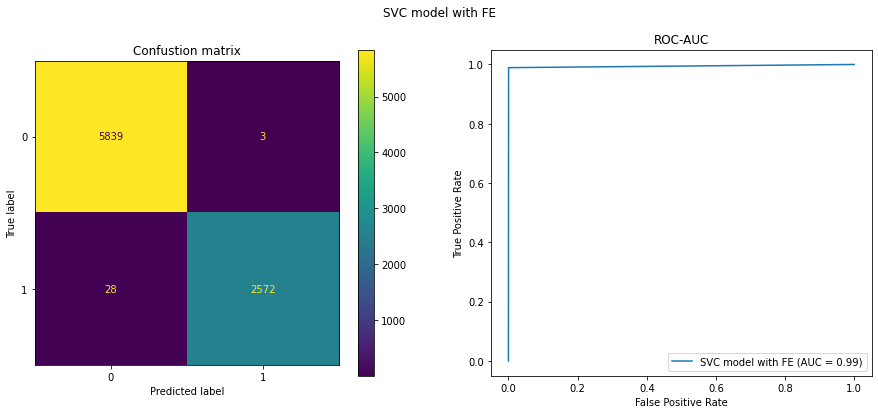

In [ ]:
model = SVC_model_FE
train_data=X_train_tfidf_FE
train_label=y_train
model_name='SVC model with FE'

print(f'Evaluating {model_name}...')
train_acc_score = model.score(train_data, train_label)
test_acc_score = model.score(X_test_tfidf_FE, y_test)

print('Training Accuracy = ',round(train_acc_score*100, 4), ' %')
print('Testing Accuracy = ',round(test_acc_score*100, 4), ' %')

y_predictions = model.predict(X_test_tfidf_FE)
print(f"F1 Score for {model_name}: {round(f1_score(y_test, y_predictions)*100,4)} %")
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predictions))

cross_val_f1 = cross_val_score(model, train_data, train_label, cv=3, scoring='f1')
print(f'cross_validation f1-scores for {model_name} \n {cross_val_f1}')

fpr, tpr, thresholds = roc_curve(y_test, y_predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name)
print("roc_auc = ", round(roc_auc*100,4))

figure, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,6))
confusion_mat.plot(ax=ax1)
ax1.set_title('Confustion matrix')
roc_display.plot(ax=ax2)
ax2.set_title('ROC-AUC')
figure.suptitle(model_name);